In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semantic-segmentation-with-carla-and-tpus/data_train/data_train/segmentation_images_04.tfrecords
/kaggle/input/semantic-segmentation-with-carla-and-tpus/data_train/data_train/segmentation_images_02.tfrecords
/kaggle/input/semantic-segmentation-with-carla-and-tpus/data_train/data_train/segmentation_images_08.tfrecords
/kaggle/input/semantic-segmentation-with-carla-and-tpus/data_train/data_train/segmentation_images_01.tfrecords
/kaggle/input/semantic-segmentation-with-carla-and-tpus/data_train/data_train/segmentation_images_03.tfrecords
/kaggle/input/semantic-segmentation-with-carla-and-tpus/data_train/data_train/segmentation_images_06.tfrecords
/kaggle/input/semantic-segmentation-with-carla-and-tpus/data_train/data_train/segmentation_images_09.tfrecords
/kaggle/input/semantic-segmentation-with-carla-and-tpus/data_train/data_train/segmentation_images_05.tfrecords
/kaggle/input/semantic-segmentation-with-carla-and-tpus/data_train/data_train/segmentation_images_07.tfrecords
/

In [2]:
# To get pi
import math

# To do linear algebra
import numpy as np

# To store data
import pandas as pd

# To create nice plots
import seaborn as sns

# To count things
from collections import Counter

# To create interactive plots
import plotly.graph_objs as go
from plotly.offline import iplot

# To handle tensors
import tensorflow as tf
import tensorflow.keras.backend as K

# To handle datasets
from kaggle_datasets import KaggleDatasets

# To create plots
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap


from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras

AUTOTUNE = tf.data.experimental.AUTOTUNE

2022-05-16 06:36:59.257384: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-16 06:36:59.257506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu
!pip install --upgrade tensorflow-tpu

     |████████████████████████████████| 1.6 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 497.5 MB 10 kB/s s eta 0:00:01
     |████████████████████████████████| 5.8 MB 30.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 47.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 41.6 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 67.7 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 35.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 28.1 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfull

## Adding support for TPU.

In [4]:
try:
    # Detect the hardware
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    # Configure tensorflow to use TPUs
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    # Get a strategy for distributing the model to TPUs
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default strategy to use CPUs or a GPU
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
MIXED_PRECISION = True
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Running on TPU  grpc://10.0.0.2:8470


2022-05-16 06:39:14.690403: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-16 06:39:14.691391: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-16 06:39:14.691443: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-16 06:39:14.691483: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (140107ff5a25): /proc/driver/nvidia/version does not exist
2022-05-16 06:39:14.693782: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('job',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
REPLICAS:  8
Mixed precision enabled
Accelerated Linear Algebra enabled


## Making a Training environmnet.

In [5]:
# Set batch size
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

# Set number of epochs
EPOCHS = 250

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

# Serialized array shape
SHAPE = (600, 800, 4)

R_SHAPE = (512, 512, 4)

# Number of classes
NUM_CLASSES = 13

#Set number of images in buffer
BUFFER_SIZE = 1024 

# Set paths to the data
PATH_DATA = 'semantic-segmentation-with-carla-and-tpus'

# Allow self optimization
AUTO = tf.data.experimental.AUTOTUNE

# Label of the classes
CLASSES = {0:'Unlabeled',
           1:'Building',
           2:'Fence',
           3:'Other',
           4:'People',
           5:'Posts',
           6:'Road Marking',
           7:'Street',
           8:'Sidewalk',
           9:'Vegatation',
           10:'Vehicle',
           11:'Wall',
           12:'Traffic Sign'}

# RGB colors of the classes
COLORS = [(80/255, 168/255, 250/255),
          (242/255, 130/255, 30/255),
          (50/255, 50/255, 50/255),
          (27/255, 44/255, 129/255),
          (163/255, 68/255, 222/255),
          (115/255, 0/255, 0/255),
          (255/255, 255/255, 255/255),
          (191/255, 191/255, 191/255),
          (150/255, 150/255, 150/255),
          (22/255, 146/255, 0/255),
          (245/255, 239/255, 46/255),
          (181/255, 103/255, 10/255),
          (235/255, 0/255, 0/255)]

## Loading Serialized dataset.

In [6]:
def loadDataset(filenames):
    # Disable order to increase speed
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    # Define a TFRecords dataset with all filenames
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    # Add options for the order to the dataset
    dataset = dataset.with_options(options)
    # Return a dataset
    dataset = dataset.map(readTFRecord, num_parallel_calls=AUTO)
    return dataset



def readTFRecord(example):
    # Parse the serialized example
    example = tf.io.parse_single_example(example, exampleStructure)
    return example['raw_image']



# Define structure of examples
exampleStructure = {'raw_image': tf.io.FixedLenFeature([np.prod(SHAPE)], tf.int64)}


# Set the path to all data files
gcs_path = KaggleDatasets().get_gcs_path(PATH_DATA)

# Get a list of all files from the training folder
train_files = tf.io.gfile.glob(gcs_path + '/data_train/data_train/*.tfrecords')
# Get a list of all files from the testing folder
test_files = tf.io.gfile.glob(gcs_path + '/data_test/data_test/*.tfrecords')


# Create datasets from file names
train_dataset = loadDataset(train_files)
test_dataset = loadDataset(test_files)

2022-05-16 06:39:21.342823: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-05-16 06:39:21.419467: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


## Labeled Graphs.

In [7]:
def countLabels(dataset):
    # Counter for the labels
    label_counter = Counter()
    
    # Number of images
    n_images = 0

    # Iterate over the whole dataset
    for image_tensor in dataset:
        
        # Count images
        n_images += 1

        # Get the label channel
        flat_mask = tf.reshape(image_tensor, SHAPE)[:,:,3].numpy()

        # Count the labels
        x = np.bincount(flat_mask.flatten())
        y = np.nonzero(x)[0]

        # Update the counter
        for key, val in zip(y,x[y]):
            label_counter[key] += val
            
    # Return counted labels and number of images
    return label_counter, n_images


# Count labels in train- and test-dataset
train_label_counts, n_train_images = countLabels(train_dataset)
test_label_counts, n_test_images = countLabels(test_dataset)


# Create dataframe for the counted train labels
df_train_label_counts = pd.DataFrame.from_dict(train_label_counts, orient='index').rename({0:'Train'}, axis=1)
df_train_label_counts.index = [CLASSES[i] for i in df_train_label_counts.index]

# Create dataframe for the counted test labels
df_test_label_counts = pd.DataFrame.from_dict(test_label_counts, orient='index').rename({0:'Test'}, axis=1)
df_test_label_counts.index = [CLASSES[i] for i in df_test_label_counts.index]


# Combine the label counts dataframes
df_label_counts = df_train_label_counts.join(df_test_label_counts)
df_label_counts = df_label_counts.stack().to_frame().reset_index().rename({'level_0':'Label', 'level_1':'Dataset', 0:'Count'}, axis=1)


##### Create Label Count Plot #####

df_tmp_train = df_label_counts[df_label_counts['Dataset']=='Train'].sort_values('Count', ascending=False)
df_tmp_test = df_label_counts[df_label_counts['Dataset']=='Test'].sort_values('Count', ascending=False)


# Set up the data
trace1 = go.Bar(y = df_tmp_train['Label'],
                x = df_tmp_train['Count'],
                base = 0,
                name = 'Train',
                textposition = 'auto',
                hovertemplate = 'Pixel:  %{x}<br>Label: %{y}',
                width = 0.4,
                marker = dict(color = '#cc3600'),
                orientation='h',
                opacity = 1.0)

trace2 = go.Bar(y = df_tmp_test['Label'],
                x = df_tmp_test['Count'],
                base = 0,
                name = 'Test',
                textposition = 'auto',
                hovertemplate = 'Pixel:  %{x}<br>Label: %{y}',
                width = 0.4,
                marker = dict(color = '#cc9c00'),
                orientation='h',
                opacity = 1.0)

# Set up the layout
layout = dict(title = 'How Many Pixels Are There Per Label?',
              xaxis = dict(title = 'Count On Logscale',
                           type='log'),
              yaxis = dict(title = 'Label'),
              font = dict(family = 'sans-serif',
                          size = 18,
                          color = '#2f2f2f'),
              plot_bgcolor = '#dddddd')

# Create the plot
fig = go.Figure(data=[trace1, trace2], layout=layout)
iplot(fig)

2022-05-16 06:40:16.227561: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 36424, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652683216.224302439","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 36424, Output num: 0","grpc_status":3}


## Random Segmaneted pictures.

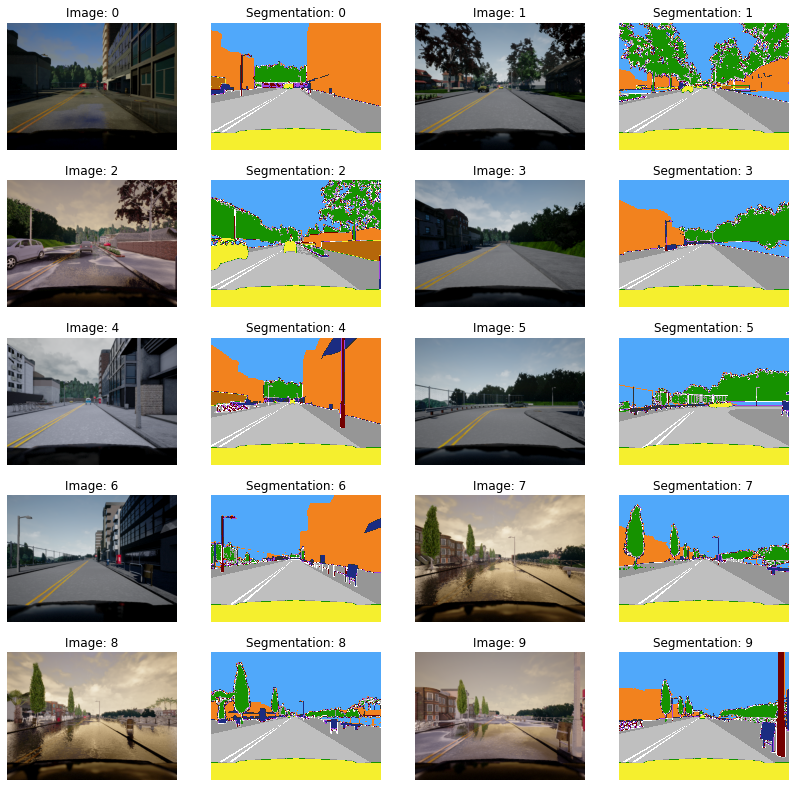

In [8]:
# Create a colormap for the labels
cm = LinearSegmentedColormap.from_list('semantic_map', 
                                       COLORS, 
                                       N=NUM_CLASSES)

# Normalize the labels
norm = Normalize(vmin=0, vmax=12)

# Setup subplots
rows, cols = 5, 4

# Create iterator for dataset tensors
tensor_iterator = iter(train_dataset)

# Create the subplots
fig, arr = plt.subplots(rows, cols, figsize=(14, 14))

# Iterate over the first images
for i in range(int(rows*cols/2)):
    
    # Get the next data tensor
    image_tensor = next(tensor_iterator)
    
    # Get the image and mask channels
    flat_image = tf.reshape(image_tensor, SHAPE)[:,:,:3].numpy()
    flat_mask = tf.reshape(image_tensor, SHAPE)[:,:,3].numpy()
    
    # Reshape the image and mask 
    image = flat_image.reshape((SHAPE[0], SHAPE[1], 3))
    mask = flat_mask.reshape((SHAPE[0], SHAPE[1]))
    
    
    # Populate the subplots
    arr[i//2][i*2%cols].imshow(image)
    arr[i//2][i*2%cols].set_title('Image: {}'.format(i))
    arr[i//2][i*2%cols].axis('off')
    arr[i//2][i*2%cols+1].imshow(mask, cmap=cm, norm=norm)
    arr[i//2][i*2%cols+1].set_title('Segmentation: {}'.format(i))
    arr[i//2][i*2%cols+1].axis('off')
plt.show()

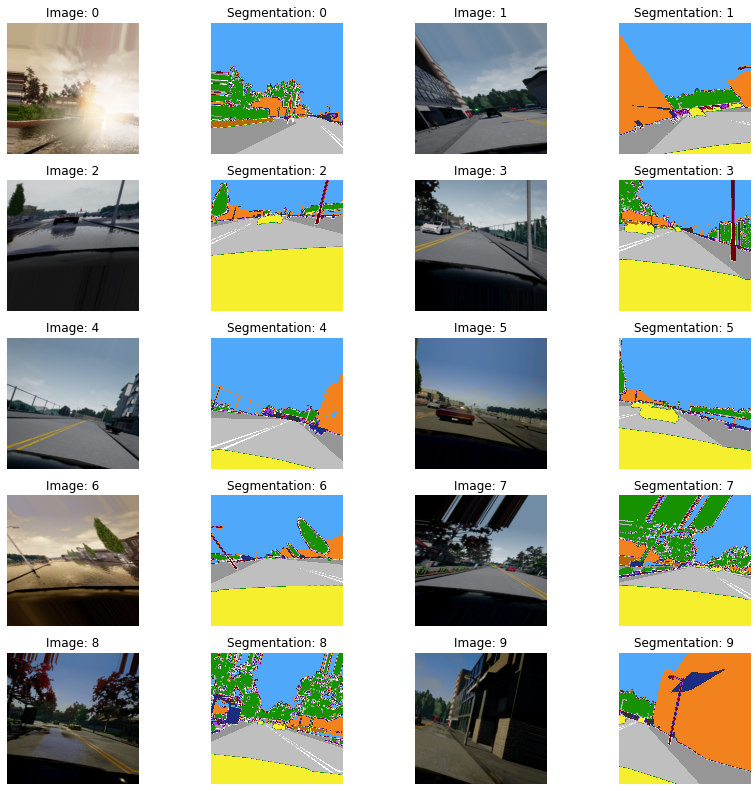

In [9]:
def trainingDataset(dataset, augmentation=True):
    # Reshape image tensor
    dataset = dataset.map(reshapeImage, num_parallel_calls=AUTO)
    
    # Perform augmentation
    if augmentation:
        # Random horizontal flip
        dataset = dataset.map(tf.image.random_flip_left_right, num_parallel_calls=AUTO)
        # Random rotation, shear, zoom and shift
        dataset = dataset.map(transformImage, num_parallel_calls=AUTO)
    
    # Split image and mask
    dataset = dataset.map(splitImage, num_parallel_calls=AUTO)
    
    # Repeat the dataset 
    dataset = dataset.repeat()
    # Set a buffersize to randomly choose images from
    dataset = dataset.shuffle(BUFFER_SIZE)
    # Set batchsize
    dataset = dataset.batch(BATCH_SIZE)
    # Prepare the next batch while training
    dataset = dataset.prefetch(AUTO)
    return dataset



def reshapeImage(tensor):
    # Reshape serialized data to tensor
    tensor = tf.reshape(tensor, SHAPE)
    return tf.image.resize(tensor, (R_SHAPE[0], R_SHAPE[1]))



def splitImage(tensor):
    # Slice image from tensor
    image = tensor[:,:,:3]
    # Slice mask from tensor
    mask = tensor[:,:,3]
    
    # Cast and normalize the ints to floats in [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0
    return image, mask



def transformImage(tensor):
    # Get dimensions of image
    dim_x, dim_y, dim_z = R_SHAPE
    
    # Get random values for the transformation
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 15. * tf.random.normal([1],dtype='float32')
    h_zoom = 1. + tf.random.normal([1],dtype='float32')/5.
    w_zoom = 1.33 + tf.random.normal([1],dtype='float32')/5.
    h_shift = 50. * tf.random.normal([1],dtype='float32')
    w_shift = 100. * tf.random.normal([1],dtype='float32')
  
    # Get transformation matrix from random transformation values
    m = transformationMatrix(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # Get a list of destination pixel indices
    x = tf.repeat( tf.range(dim_x//2, -dim_x//2, -1), dim_y )
    y = tf.tile( tf.range(-dim_y//2,dim_y//2), [dim_x] )
    z = tf.ones([dim_x*dim_y], dtype='int32')
    idx = tf.stack( [x, y, z] )
    
    # Rotate the destination pixels onto the origin pixels
    idx2 = K.dot(m, tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -dim_x//2+1, dim_x//2)
    
    # Find origin pixel values
    idx3 = tf.stack( [dim_x//2-idx2[0,], dim_x//2-1+idx2[1,]] )
    d = tf.gather_nd(tensor, tf.transpose(idx3))
    
    # Return transformed image
    return tf.reshape(d, R_SHAPE)



def transformationMatrix(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    ##### Create a single 3x3 transformation matrix from 4 individual transformations #####
        
    # Convert degrees to radians
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # Rotation matrix
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # Shear matrix
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # Zoom matrix
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # Shift matrix
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    # Combine all four transformation matrices into a single transformation matrix
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))



def testingDataset(dataset):
    # Reshape image tensor
    dataset = dataset.map(reshapeImage, num_parallel_calls=AUTO)
    
    # Split image and mask
    dataset = dataset.map(splitImage, num_parallel_calls=AUTO)
    
    # Set batchsize
    dataset = dataset.batch(BATCH_SIZE)
    # Prepare the next batch while training
    dataset = dataset.prefetch(AUTO)
    return dataset



# Get the training dataset
train_dataset = trainingDataset(train_dataset, augmentation=True)

# Create iterator for dataset tensors
train_dataset_iterator = iter(train_dataset.unbatch())

# Create the subplots
fig, arr = plt.subplots(5, 4, figsize=(14, 14))

# Iterate over the first images
for i in range(10):
    
    # Get the next image and mask
    image, mask = next(train_dataset_iterator)
    
    
    # Populate the subplots
    arr[i//2][i*2%4].imshow(image)
    arr[i//2][i*2%4].set_title('Image: {}'.format(i))
    arr[i//2][i*2%4].axis('off')
    arr[i//2][i*2%4+1].imshow(mask, cmap=cm, norm=norm)
    arr[i//2][i*2%4+1].set_title('Segmentation: {}'.format(i))
    arr[i//2][i*2%4+1].axis('off')
plt.show()

## Defining a model.

In [10]:
OUTPUT_CHANNELS = 13
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(input_shape=[512, 512, 3], include_top=False)
    
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.momentum = 0.9

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
layer_names = [
    'block_1_expand_relu',   
    'block_3_expand_relu',   
    'block_6_expand_relu',   
    'block_13_expand_relu',  
    'out_relu',      
]
m_layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
with strategy.scope():
    down_stack = keras.Model(inputs=base_model.input, outputs=m_layers)
    down_stack.trainable = True

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.3))

    result.add(layers.ReLU())

    return result

In [13]:
def ResidualBlock(filters, size, pad='same'):
    initializer1 = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    initializer2 = tf.random_normal_initializer(0., 0.02)
    
    model = tf.keras.Sequential()
#     model.add(ReflectionPadding2D())
    model.add(tf.keras.layers.Conv2D(filters,size, padding=pad, kernel_initializer=initializer1, use_bias=False))
    model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    model.add(tf.keras.layers.Activation('relu'))
#     model.add(ReflectionPadding2D())
    model.add(tf.keras.layers.Conv2D(filters,size, padding=pad, kernel_initializer=initializer2, use_bias=False))
    model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))  
    return model

In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.W3 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, x1, x2):
        
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(x1) + self.W3(x2)))


        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=-1)

        context_vector = attention_weights * features
        
        return context_vector
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'W1': self.W1,
            'W2': self.W2,
            'W3': self.W3,
            'V': self.V
        })
        return config

In [15]:
def unet_model(output_channels=13):
    
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])
    
    x = inputs
    
    at = BahdanauAttention(128)(x, x, x)
    
    x = tf.keras.layers.add([x, at])
    
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    
    f_inputs = x
    
    mid_skips = []
    
    res_block = [
        ResidualBlock(320,3, 'same'),
        ResidualBlock(320,3, 'same'),
        ResidualBlock(320,3, 'same'),
#         ResidualBlock(2048,3, 'same'),
#         ResidualBlock(1024,1, 'same'),
#         ResidualBlock(1024,1, 'same'),
    ]
    
    up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]
    
#     up_stack = [
#     pix2pix.upsample(512, 3),  # 4x4 -> 8x8
#     pix2pix.upsample(256, 3),  # 8x8 -> 16x16
#     pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#     pix2pix.upsample(64, 3),   # 32x32 -> 64x64
# ]




    
    mid_res = [ [ResidualBlock(64,3, 'same'),ResidualBlock(64,3, 'same')], [ResidualBlock(128,3, 'same'),ResidualBlock(128,3, 'same')], 
              [ResidualBlock(256,3, 'same'),ResidualBlock(256,3, 'same')],
              [ResidualBlock(512,3, 'same'),ResidualBlock(512,3, 'same')], [0] ]    
    
    
  # Downsampling through the model
    skips = down_stack(x)
#     x = skips[-1]

    
    
    for skip, res_down in zip(skips, mid_res):
        x = skip
        x1 = x
        if 0 not in res_down:
            for res in res_down:
                x1 = res(x1)
                at = BahdanauAttention(128)(x1, x1, x1)
                x1 = tf.keras.layers.add([x1, at])
                x1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x1)
                
            mid_skips.append(x1)  
            
    temp = x
    
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    x = layers.Conv2D(320, 3, padding='same', kernel_initializer=initializer)(x)
    
    x = layers.LeakyReLU()(x)
    
    at = BahdanauAttention(128)(x, x, x)
    
    x = tf.keras.layers.add([x, at])
    
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)

    
    for r in res_block:
        x1 = x
        x2 = r(x)
        
        x = tf.keras.layers.add([x1, x2])
        at = BahdanauAttention(128)(x, x, x)
        x = tf.keras.layers.add([x, at])
        x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
        
    x = layers.Concatenate()([x, temp])
    
    at = BahdanauAttention(128)(x, x, x)
    x = tf.keras.layers.add([x, at])
    x = tf.keras.layers.BatchNormalization()(x)
    
    skips = reversed(skips[:-1])
    mid_skips = reversed(mid_skips)


  # Upsampling and establishing the skip connections
    for up, skip, mid_skip in zip(up_stack, skips, mid_skips):
        x = up(x)
        at = BahdanauAttention(128)(x, mid_skip, skip)
        x = tf.keras.layers.add([x, at])
        x = tf.keras.layers.BatchNormalization()(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip, mid_skip])
        at = BahdanauAttention(128)(x, x, x)
        x = tf.keras.layers.add([x, at])
        x = tf.keras.layers.BatchNormalization()(x)

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      32, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)
    
    x = layers.LeakyReLU()(x)
    
    at = BahdanauAttention(128)(x, x, x)
    x = tf.keras.layers.add([x, at])
    x = tf.keras.layers.BatchNormalization()(x)
    
    conv_inp1 = ResidualBlock(32,3, 'same')(f_inputs)
    conv_inp2 = ResidualBlock(32,3, 'same')(conv_inp1)
    
    at = BahdanauAttention(128)(x, conv_inp1, conv_inp2)
    x = tf.keras.layers.add([x, at])
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = layers.Concatenate()([x, conv_inp1, conv_inp2])
    
    at = BahdanauAttention(128)(x, x, x)
    x = tf.keras.layers.add([x, at])
    x = tf.keras.layers.BatchNormalization()(x)
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    x = layers.Conv2D(output_channels, 1, padding='same', kernel_initializer=initializer, activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
with strategy.scope():
    model = unet_model(13)
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
bahdanau_attention (BahdanauAtt (None, 512, 512, 3)  1665        input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
add (Add)                       (None, 512, 512, 3)  0           input_2[0][0]                    
                                                                 bahdanau_attention[0][0]   

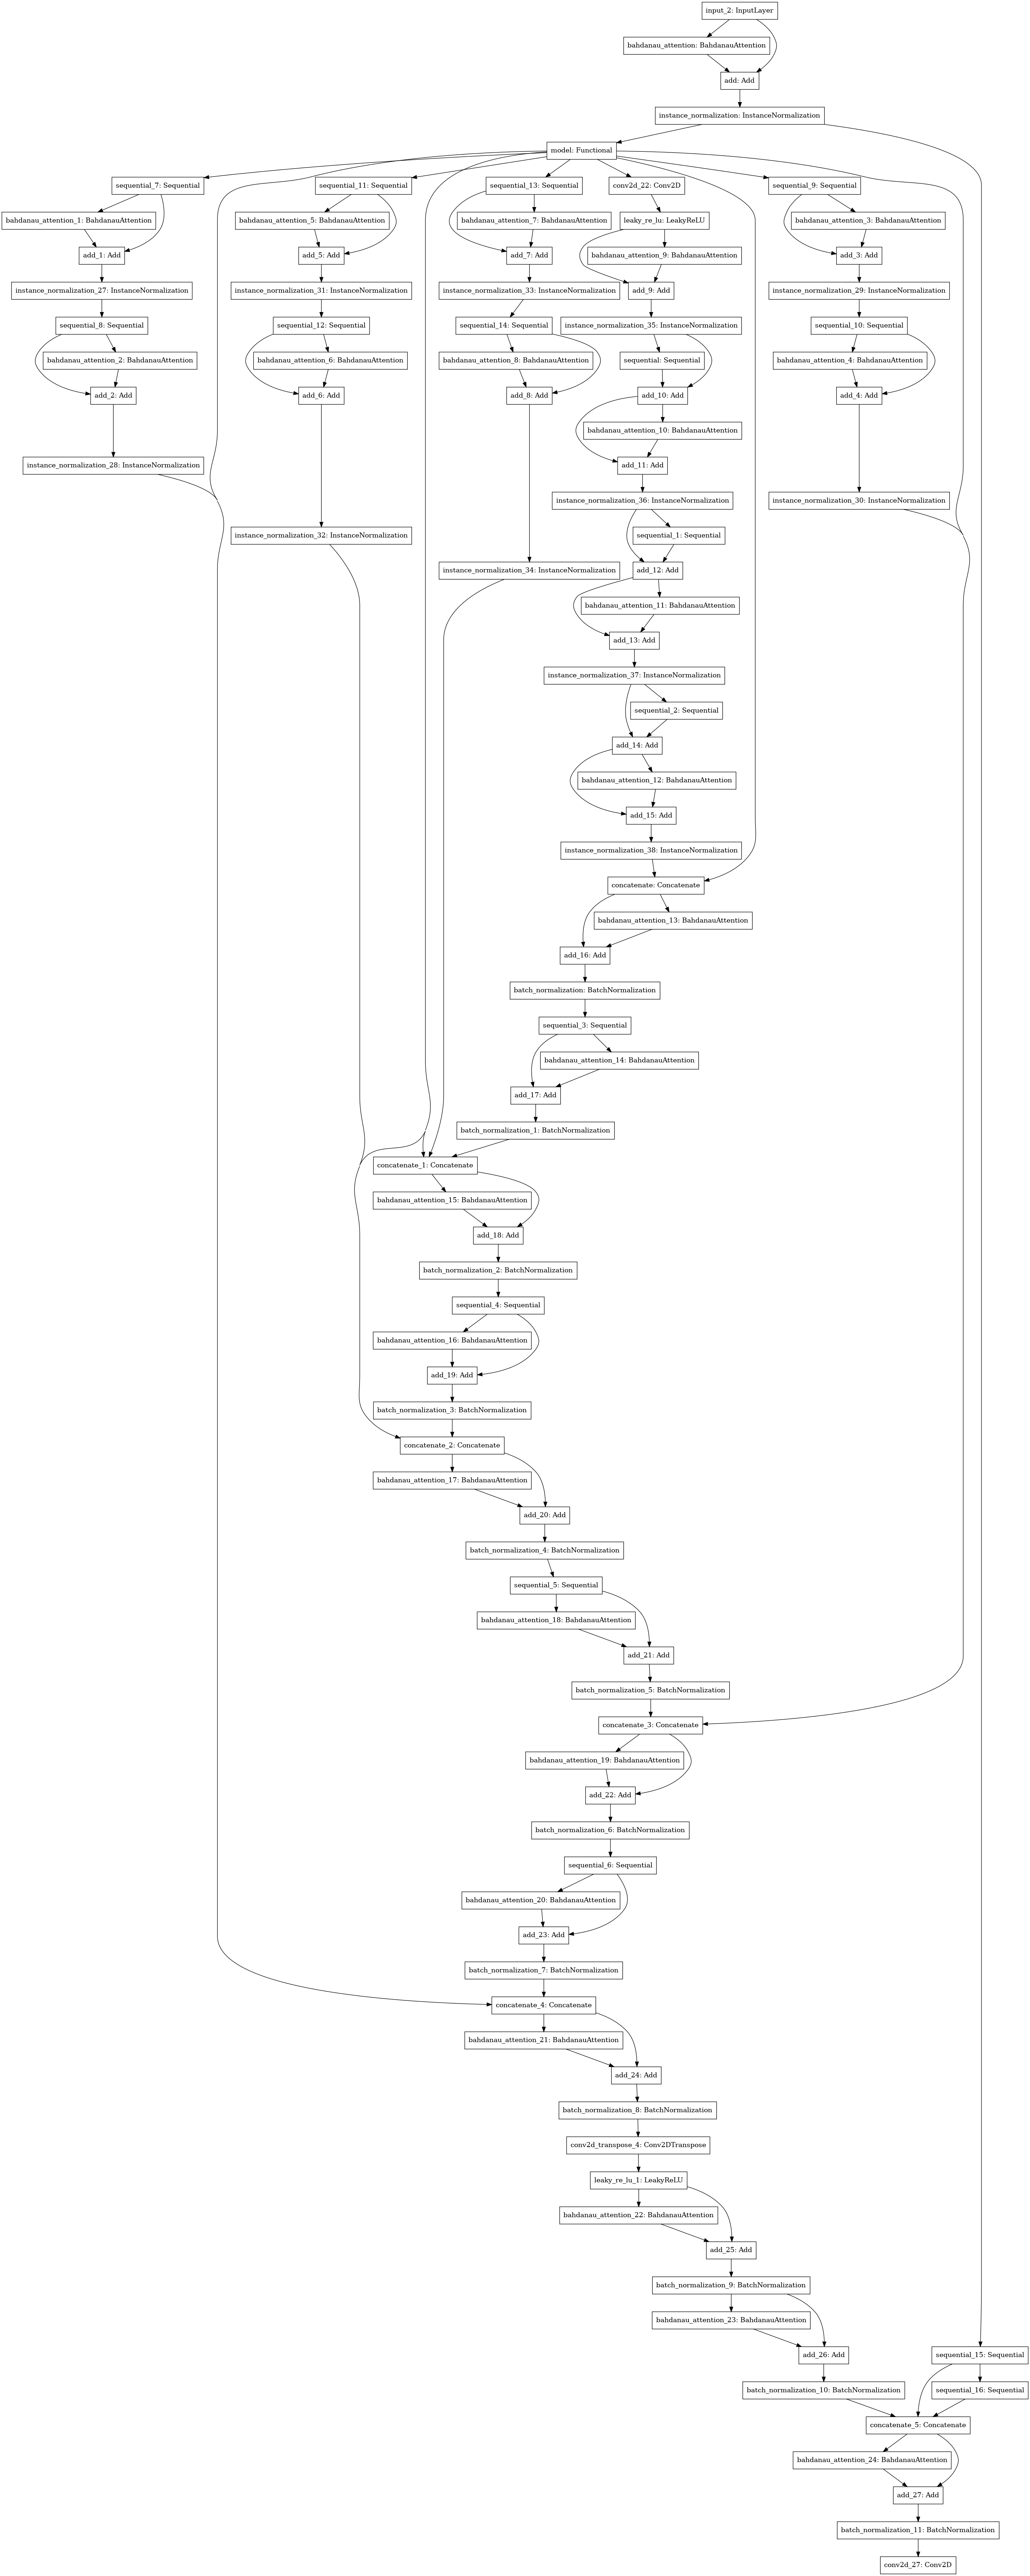

In [18]:
tf.keras.utils.plot_model(model, show_shapes=False)

## Main model training.

In [19]:
# Get the train- and test-dataset
train_dataset = trainingDataset(loadDataset(train_files), augmentation=True)
test_dataset = testingDataset(loadDataset(test_files))


# Setup callbacks
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1, factor=0.5, min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=STOPPING_PATIENCE, verbose=1, restore_best_weights=True)


# Fit the model to the data
history = model.fit(train_dataset, 
                    steps_per_epoch = int(n_train_images / BATCH_SIZE),
                    epochs = EPOCHS,
                    callbacks = [early_stopping, learning_rate],
                    validation_data = test_dataset,
                    validation_steps = int(n_test_images / BATCH_SIZE))

Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ResourceExhaustedError: 9 root error(s) found.
  (0) Resource exhausted: {{function_node __inference_train_function_159869}} Compilation failure: Ran out of memory in memory space hbm. Used 15.61G of 15.48G hbm. Exceeded hbm capacity by 133.85M.

Total hbm usage >= 16.13G:
    reserved        530.00M 
    program          15.12G 
    arguments       506.42M (96.3% utilization)

Output size 474.42M (96.1% utilization); shares 474.41M with arguments.

Program hbm requirement 15.12G:
    global            36.0K
    scoped           43.62M
    HLO temp         14.87G (70.0% utilization: Unpadded (10.40G) Padded (14.85G), 0.1% fragmentation (19.38M))
    overlays        207.96M

  Largest program allocations in hbm:

  1. Size: 512.00M
     Operator: op_type="Conv2D" op_name="model_1/sequential_16/conv2d_26/Conv2D"
     Shape: bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)}
     Unpadded size: 128.00M
     Extra memory due to padding: 384.00M (4.0x expansion)
     XLA label: %fusion.627 = (f32[8,32]{1,0:T(8,128)}, bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)}) fusion(s32[]{:T(256)} %get-tuple-element.31748, f32[3,3,32,32]{3,2,1,0:T(8,128)} %get-tuple-element.33350, bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)} %get-tuple-element.31659...
     Allocation type: HLO temp
     ==========================

  2. Size: 512.00M
     Operator: op_type="Conv2D" op_name="model_1/sequential_16/conv2d_25/Conv2D"
     Shape: bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)}
     Unpadded size: 128.00M
     Extra memory due to padding: 384.00M (4.0x expansion)
     XLA label: %fusion.625 = (f32[8,32]{1,0:T(8,128)}, bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)}) fusion(s32[]{:T(256)} %get-tuple-element.31748, bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)} %get-tuple-element.30734, f32[3,3,32,32]{3,2,1,0:T(8,128)} %get-tuple-element.33349...
     Allocation type: HLO temp
     ==========================

  3. Size: 512.00M
     Operator: op_type="Conv2D" op_name="model_1/sequential_15/conv2d_24/Conv2D"
     Shape: bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)}
     Unpadded size: 128.00M
     Extra memory due to padding: 384.00M (4.0x expansion)
     XLA label: %fusion.623 = (f32[8,32]{1,0:T(8,128)}, bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)}) fusion(s32[]{:T(256)} %get-tuple-element.31748, f32[3,3,32,32]{3,2,1,0:T(8,128)} %get-tuple-element.33344, bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)} %get-tuple-element.31531...
     Allocation type: HLO temp
     ==========================

  4. Size: 512.00M
     Operator: op_type="Conv2D" op_name="model_1/sequential_15/conv2d_23/Conv2D"
     Shape: bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)}
     Unpadded size: 128.00M
     Extra memory due to padding: 384.00M (4.0x expansion)
     XLA label: %fusion.621 = (f32[8,32]{1,0:T(8,128)}, bf16[8,512,512,32]{3,0,2,1:T(8,128)(2,1)}) fusion(s32[]{:T(256)} %get-tuple-element.31748, f32[3,3,3,32]{3,2,1,0:T(4,128)} %get-tuple-element.33343, bf16[8,3]{0,1:T(4,128)(2,1)} %get-tuple-element.30888, bf16[8,3]{0,...
     Allocation type: HLO temp
     ==========================

  5. Size: 512.00M
     Operator: op_type="Conv2DB ... [truncated]